## MNIST using TensorFlow

* Taken from: https://www.analyticsvidhya.com/blog/2016/10/an-introduction-to-implementing-neural-networks-using-tensorflow/

Need to answer this: How is this a MLP and what is it?

In [21]:
%pylab inline

import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


/home/anuj/.virtualenvs/video-analytics-2/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed', 'imread', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [26]:
root_dir = os.path.abspath('../..')
data_dir = os.path.join(root_dir, 'data')
sub_dir = os.path.join(root_dir, 'sub')
print(root_dir)
print(data_dir)
print(sub_dir)

# check for existence
os.path.exists(root_dir)
os.path.exists(data_dir)
os.path.exists(sub_dir)

/home/anuj/git
/home/anuj/git/data
/home/anuj/git/sub


True

In [28]:
train = pd.read_csv(os.path.join(data_dir, 'Train', 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'Test.csv'))

sample_submission = pd.read_csv(os.path.join(data_dir, 'Sample_Submission.csv'))

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


/home/anuj/.virtualenvs/video-analytics-2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


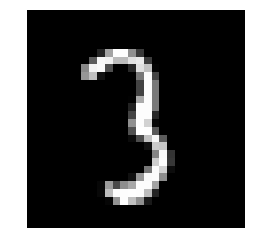

In [30]:
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)

img = imread(filepath, flatten=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [34]:
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

temp = []
for img_name in test.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
test_x = np.stack(temp)

/home/anuj/.virtualenvs/video-analytics-2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/anuj/.virtualenvs/video-analytics-2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]


In [35]:
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train.label.values[:split_size], train.label.values[split_size:]

In [36]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    
    return temp_batch

def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, input_num_units)
    batch_x = preproc(batch_x)
    
    if dataset_name == 'train':
        batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
        batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y


In [37]:
### set all variables

# number of neurons in each layer
input_num_units = 28*28
hidden_num_units = 500
output_num_units = 10


In [38]:

# define placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])


In [39]:
# set remaining variables
epochs = 5
batch_size = 128
learning_rate = 0.01


In [40]:
### define weights and biases of the neural network (refer this article if you don't understand the terminologies)

weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units], seed=seed))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed))
}

In [41]:
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']


In [42]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer, labels=y))

In [43]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [44]:
init = tf.global_variables_initializer()

In [45]:
with tf.Session() as sess:
    # create initialized variables
    sess.run(init)
    
    ### for each epoch, do:
    ###   for each batch, do:
    ###     create pre-processed batch
    ###     run optimizer by feeding batch
    ###     find cost and reiterate to minimize
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            
            avg_cost += c / total_batch
            
        print "Epoch:", (epoch+1), "cost =", "{:.5f}".format(avg_cost)
    
    print "\nTraining complete!"
    
    
    # find predictions on val set
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print "Validation Accuracy:", accuracy.eval({x: val_x.reshape(-1, input_num_units), y: dense_to_one_hot(val_y)})
    
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x: test_x.reshape(-1, input_num_units)})

/home/anuj/.virtualenvs/video-analytics-2/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Epoch: 1 cost = 8.95139
Epoch: 2 cost = 1.85083
Epoch: 3 cost = 0.90416
Epoch: 4 cost = 0.57321
Epoch: 5 cost = 0.44519

Training complete!
Validation Accuracy: 0.95891154


Prediction is:  2


/home/anuj/.virtualenvs/video-analytics-2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


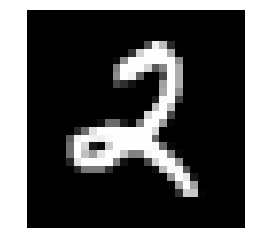

In [63]:
img_name = rng.choice(test.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)

img = imread(filepath, flatten=True)

test_index = int(img_name.split('.')[0]) - 49000

print "Prediction is: ", pred[test_index]

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [50]:
sample_submission.filename = test.filename

sample_submission.label = pred

sample_submission.to_csv(os.path.join(sub_dir, 'sub01.csv'), index=False)